<a href="https://colab.research.google.com/github/SabaDyal/Cotton-Disease-Predictor/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = os.path.join(os.path.dirname('/content/gdrive/MyDrive/cotton dataset/crops_diseases'))

Mounted at /content/gdrive


In [ ]:
IMAGE_SIZE=617
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/gdrive/MyDrive/cotton dataset/crops_diseases',
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1010 files belonging to 4 classes.


In [ ]:
class_names= dataset.class_names
class_names

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [ ]:
len(dataset)

32

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 617, 617, 3)
[0 3 1 3 0 0 3 2 3 1 1 1 3 1 0 1 1 0 0 3 0 0 3 3 1 3 0 1 1 3 0 3]


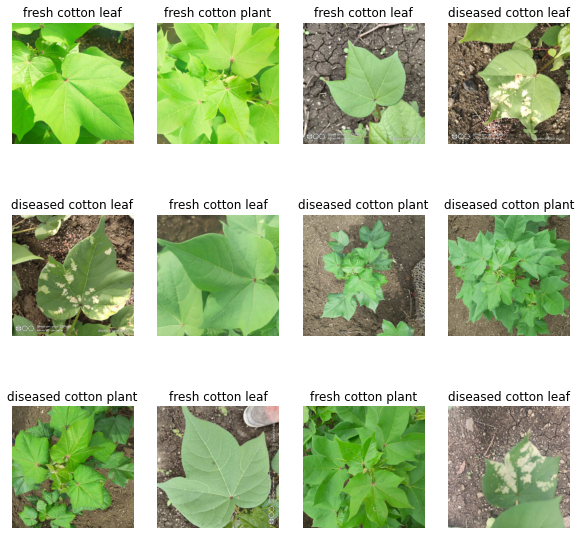

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
train_size = 0.8
len(dataset)*train_size

25.6

In [ ]:
train_ds = dataset.take(25)
len(train_ds)

25

In [ ]:
test_ds = dataset.skip(25)
len(test_ds)

7

In [ ]:
val_ds=test_ds.take(4)
len(val_ds)

4

In [ ]:
test_ds = test_ds.skip(4)
len(test_ds)

3

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
     
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [ ]:
input_shape =(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS )
n_classes= 4

model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3) , activation='relu' , input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size = (3,3), activation='relu'  ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size = (3,3), activation='relu'  ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,(3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,(3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,(3,3) , activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 , activation='relu'),
    layers.Dense( n_classes , activation='softmax'),
])
model.build( input_shape =input_shape )

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 617, 617, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 617, 617, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 615, 615, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 307, 307, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 305, 305, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 152, 152, 64)       0         
 2D)                                                  

In [ ]:
model.compile(
optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data= val_ds
)

Epoch 1/30
25/25 [==============================] - 208s 1s/step - loss: 1.3395 - accuracy: 0.3262 - val_loss: 1.1689 - val_accuracy: 0.5417
Epoch 2/30
25/25 [==============================] - 17s 667ms/step - loss: 1.0535 - accuracy: 0.5487 - val_loss: 0.8387 - val_accuracy: 0.6875
Epoch 3/30
25/25 [==============================] - 17s 668ms/step - loss: 0.8019 - accuracy: 0.6737 - val_loss: 0.7030 - val_accuracy: 0.7396
Epoch 4/30
25/25 [==============================] - 17s 669ms/step - loss: 0.6765 - accuracy: 0.7300 - val_loss: 0.6283 - val_accuracy: 0.7812
Epoch 5/30
25/25 [==============================] - 17s 667ms/step - loss: 0.7834 - accuracy: 0.6587 - val_loss: 0.6813 - val_accuracy: 0.7083
Epoch 6/30
25/25 [==============================] - 17s 665ms/step - loss: 0.5924 - accuracy: 0.7600 - val_loss: 0.4723 - val_accuracy: 0.7604
Epoch 7/30
25/25 [==============================] - 17s 666ms/step - loss: 0.5349 - accuracy: 0.7675 - val_loss: 0.5161 - val_accuracy: 0.7812
E

In [ ]:
scores= model.evaluate(test_ds)

4/4 [==============================] - 9s 224ms/step - loss: 0.1671 - accuracy: 0.9453


In [ ]:
history

In [ ]:
history.history['accuracy']

[0.32624998688697815,
 0.5487499833106995,
 0.6737499833106995,
 0.7300000190734863,
 0.6587499976158142,
 0.7599999904632568,
 0.7674999833106995,
 0.75,
 0.8125,
 0.8062499761581421,
 0.831250011920929,
 0.8837500214576721,
 0.8899999856948853,
 0.8462499976158142,
 0.887499988079071,
 0.918749988079071,
 0.8987500071525574,
 0.8812500238418579,
 0.9100000262260437,
 0.9237499833106995,
 0.9300000071525574,
 0.9337499737739563,
 0.9337499737739563,
 0.9412500262260437,
 0.9537500143051147,
 0.9399999976158142,
 0.9399999976158142,
 0.9375,
 0.9437500238418579,
 0.9049999713897705]

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history ['val_loss']

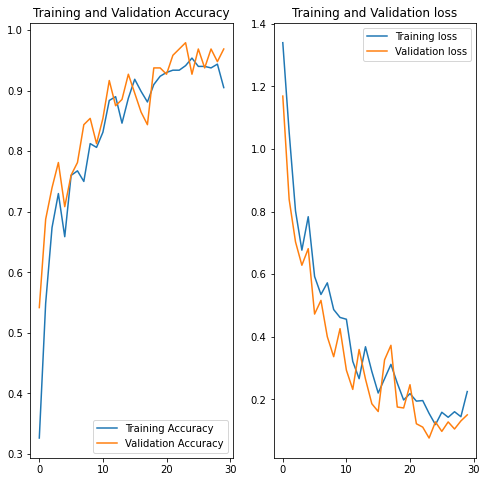

In [ ]:
plt.figure(figsize=(8 ,8))
plt.subplot(1 ,2 ,1)
plt.plot(range(EPOCHS) , acc , label='Training Accuracy')
plt.plot(range(EPOCHS) , val_acc , label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1 ,2 ,2)
plt.plot(range(EPOCHS) , loss , label='Training loss')
plt.plot(range(EPOCHS) , val_loss , label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

first image to pridict
actual label: fresh cotton leaf
diseased cotton leaf


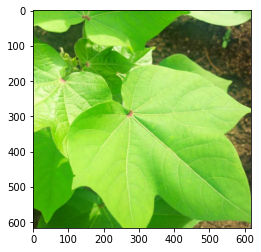

In [ ]:
for images_batch , labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()
  
  print("first image to pridict")
  plt.imshow(first_image)
  print("actual label:" ,class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print(class_names[np.argmax(batch_prediction[0])])



In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round (100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence 
  

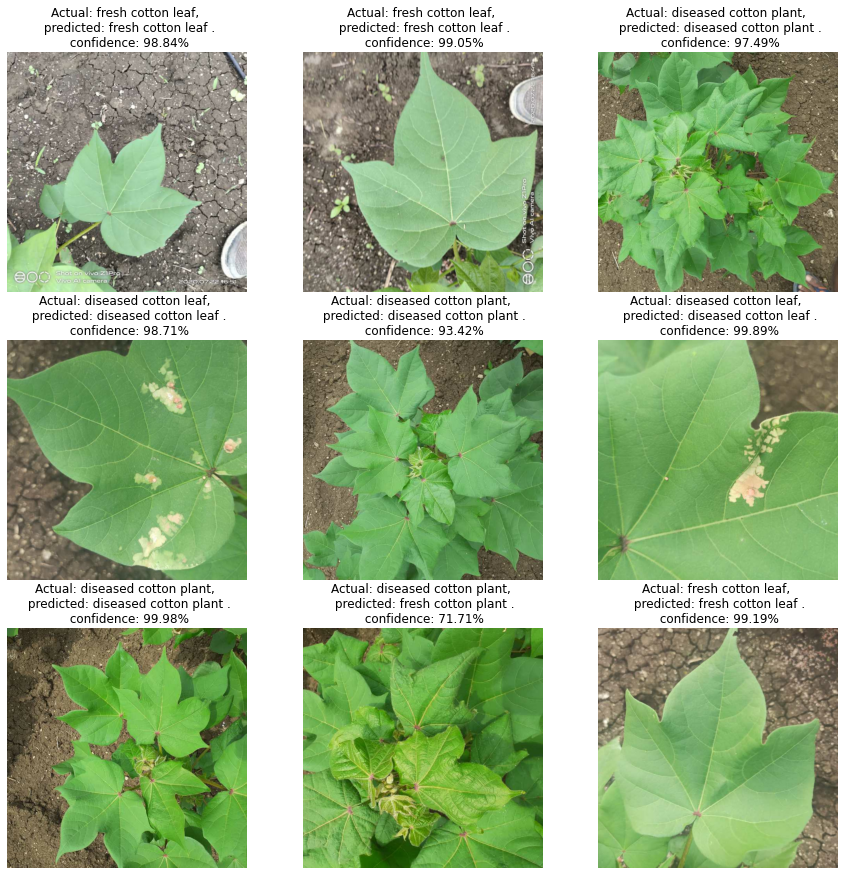

In [ ]:
plt.figure(figsize=(15, 15))
for images , labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n predicted: {predicted_class} .\n confidence: {confidence}%")

    plt.axis("off")